In [1]:
from sklearn.datasets import fetch_olivetti_faces
import sys
import matplotlib.pyplot as plt
import numpy as np
import importlib
import pickle
import os
from skimage.color import rgb2gray


In [2]:
def unravel_image(image):
    num_pixels = image.shape[0]*image.shape[1]
    image_vector = np.reshape(image,(num_pixels))
    return image_vector
def ravel_image_vec(image_vector,num_pixels_per_side):
    image = np.reshape(image_vector,(num_pixels_per_side,num_pixels_per_side),'F')
    image = image.T
    return image
def project_onto_eig_vecs(vec1,eig_vecs):
    #Recall that VV^T is the matrix of orthogonal projection.
    return eig_vecs@eig_vecs.T@vec1
    

In [191]:
def plot_image_grid(images, title, image_shape=(64,64),n_col=5, n_row=2, bycol=0, row_titles=None,col_titles=None):
    fig,axes = plt.subplots(nrows=n_row,ncols=n_col,figsize=(2. * n_col, 2.26 * n_row))
    for i, comp in enumerate(images):
        row,col = reversed(divmod(i,n_row)) if bycol else divmod(i,n_col)       
        cax = axes[col]
        cax.imshow(comp.reshape(image_shape), cmap='gray',
                   interpolation='nearest',
                   vmin=comp.min(), vmax=comp.max())
        cax.set_xticks(())
        cax.set_yticks(())
    if row_titles is not None :
        for ax,row in zip(axes[:,0],row_titles) :
            ax.set_ylabel(row,size='large')
    if col_titles is not None :
        for ax,col in zip(axes[0],col_titles) :
            ax.set_title(col)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(title + '.pdf',bbox_inches='tight')
    plt.show()

# Make Graphs of "Eigenfaces"


In [192]:
file='../analysis_data/celebA_orig_eigen.p'
eig_val_vecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-5:] 
    images = np.flipud(images)
    plot_title = 'CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape,nrows=1,ncols=5)


TypeError: plot_image_grid() got an unexpected keyword argument 'nrows'

In [ ]:
file='../analysis_data/celebA_recons_eigen.p'
eig_val_vecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-5:] 
    images = np.flipud(images)
    plot_title = 'Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape,n_rows=1,n_cols=5)


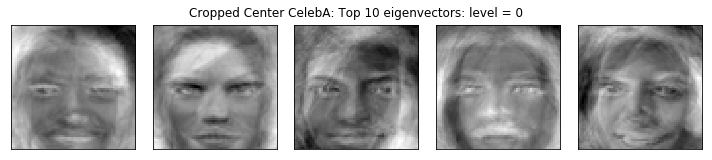

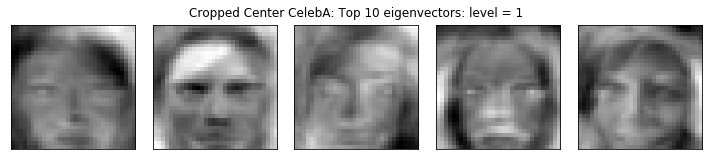

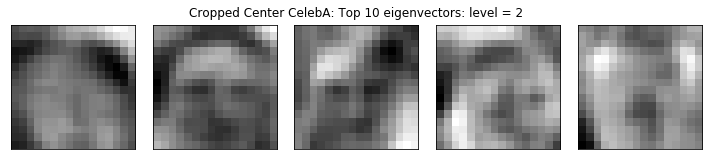

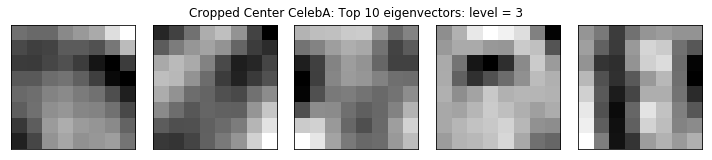

In [199]:
file='../analysis_data/celebA_orig_cropped_eigen.p'
eig_val_vecs = pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Cropped Center CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(-images,plot_title ,image_shape=eig_vecs[0].shape,n_row=1,n_col=5)


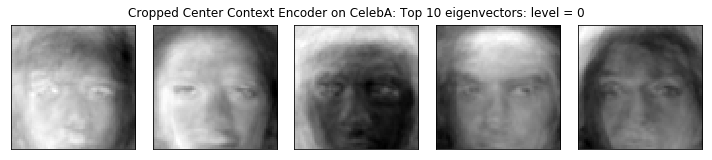

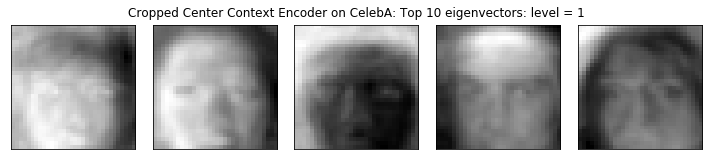

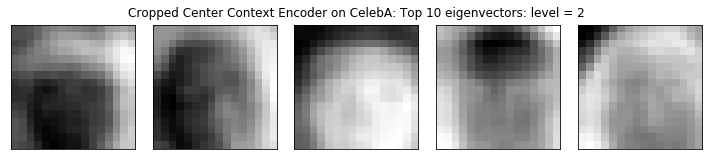

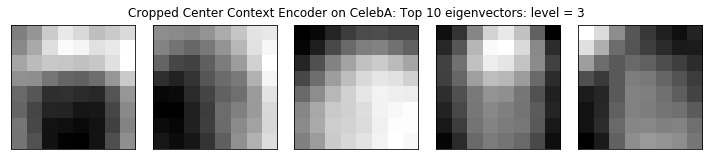

In [200]:
file='../analysis_data/celebA_recons_cropped_eigen.p'
eig_val_vecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-5:] 
    images = np.flipud(images)
    plot_title = 'Cropped Center Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(-images,plot_title ,image_shape=eig_vecs[0].shape,n_row=1,n_col=5)

# PCA Analysis

In [147]:
file1='../analysis_data/celebA_orig_cropped_eigen.p'
file2='../analysis_data/celebA_recons_cropped_eigen.p'
orig_cropped_eig=pickle.load(open(file1,'rb'))
recons_cropped_eig=pickle.load(open(file2,'rb'))

In [148]:
input_image_dir = '../nn_output/'
original_images_path_list = []
for file in os.listdir(input_image_dir):
    if file.endswith("orig.png"):
        original_images_path_list.append(file)
original_images = [rgb2gray(plt.imread(input_image_dir+file)) for file in sorted(original_images_path_list)]
original_cropped = [image[32:(32+64), 32:(32+64)] for image in original_images]



reconstructed_images_path_list = []

for file in os.listdir(input_image_dir):
    if file.endswith("recons.png"):
        reconstructed_images_path_list.append(file)

recons_images = [rgb2gray(plt.imread(input_image_dir+file)) for file in sorted(reconstructed_images_path_list)]
recons_cropped = [image[32:(32+64), 32:(32+64)] for image in recons_images]

In [126]:
sorted(original_images_path_list)[6:10]

['000007_orig.png', '000008_orig.png', '000009_orig.png', '000010_orig.png']

### Level=0 (64x64)

In [10]:
orig_eig_vals = orig_cropped_eig[0][0]
orig_eig_images = orig_cropped_eig[0][1]
recons_eig_vals = recons_cropped_eig[0][0]
recons_eig_images = recons_cropped_eig[0][1]


In [11]:
sum(orig_eig_vals)

14638.01732027455

(64p x 64p) The total variance in the original images is 14638.

In [12]:
sum(recons_eig_vals)

12271.531987335558

In [179]:
sum(recons_eig_vals)/sum(orig_eig_vals)

0.83833293258498442

The total variance in the reconstructed images is 12271.

Now lets compare the variance captured in the first 10 eigenvectors for the original images and reconstructed images

In [13]:
orig_eig_vals[-10:]

array([  269.44006234,   322.70747238,   347.01547286,   381.40298978,
         443.63450053,   717.15863663,  1054.85662082,  1697.88216015,
        2274.95680118,  2911.96924509])

In [14]:
recons_eig_vals[-10:]

array([  209.89957259,   232.78258088,   244.48106084,   283.30907265,
         352.04373035,   658.08107985,   958.99345968,  1560.69588828,
        1993.52560002,  2892.08086622])

We can see that the eigenvectors for the original images seem to capture more variance.

# Variance Captured graph

$EC= \frac{||Proj_{Q_r}(Im)||_2}{||Im||_2}$

In [127]:
def variance_captured(image_vec, eig_vecs): 
    return np.linalg.norm(eig_vecs@eig_vecs.T@image_vec)
    

In [174]:
orig_total_dataset_var = sum(orig_eig_vals)
orig_cumulative_var_captured=[sum(orig_eig_vals[-ii:]/orig_total_dataset_var) for ii in range(1,len(orig_eig_vals))]

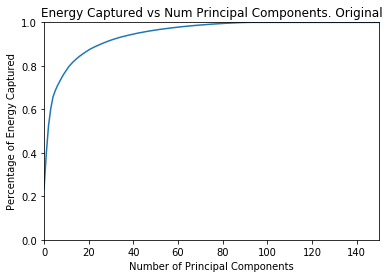

In [175]:
plt.plot(cumulative_var_captured)
plt.title("Energy Captured vs Num Principal Components. Original")
plt.ylabel('Percentage of Energy Captured')
plt.xlabel('Number of Principal Components')
plt.xlim([0,150])
plt.ylim([0,1])
plt.show()


In [176]:
total_dataset_var = sum(recons_eig_vals)
recons_cumulative_var_captured=[sum(recons_eig_vals[-ii:]/orig_total_dataset_var) for ii in range(1,len(recons_eig_vals))]

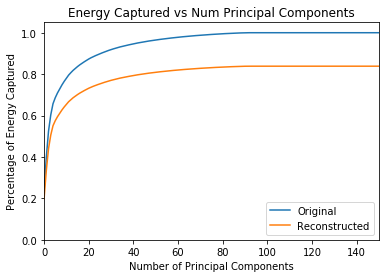

In [184]:
plt.plot(cumulative_var_captured,label="Original")
plt.plot(recons_cumulative_var_captured,label="Reconstructed")
plt.title("Energy Captured vs Num Principal Components")
plt.ylabel('Percentage of Energy Captured')
plt.xlabel('Number of Principal Components')
plt.legend(loc='lower right')
plt.xlim([0,150])
plt.ylim([0,1.05])
plt.show()


# Energy capture of individual images (THIS SECTION IS BORKED)

In [115]:
cum_compressed_var_captured=[]
total_dataset_var = sum(orig_eig_vals)
n_dim=250
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))

for ii,eig_image in enumerate(recons_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)



In [116]:
var_captured_list=[]
for ii in range(1,200):
    perc_energy_list = []
    #Compressed image for loop
    for image in recons_eig_images[10:20]:
        image_vec = unravel_image(image)
        perc_energy_captured = variance_captured(image_vec,image_eig_vecs[:,-ii:])/np.linalg.norm(image_vec)
        perc_energy_list.append(perc_energy_captured)
    avg_perc_energy_cap = np.mean(perc_energy_list)
    
    
    var_captured_list.append(avg_perc_energy_cap)


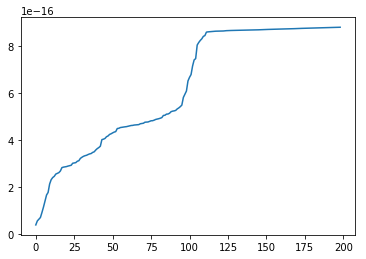

In [113]:
plt.plot(var_captured_list)
plt.show()

compressed_image_energy_list

In [50]:
image_eig_vecs.T

array([[  0.00000000e+00,   9.55469756e-04,   9.27714449e-04, ...,
          1.53785961e-02,   1.72661253e-03,   1.35058030e-02],
       [  0.00000000e+00,   1.02162256e-03,  -3.54114412e-04, ...,
         -2.05163546e-03,   4.64087967e-03,   6.72944723e-03],
       [  0.00000000e+00,   1.20610580e-04,   9.28374628e-04, ...,
         -1.01995733e-02,  -3.18337827e-02,   1.64455210e-02],
       ..., 
       [  1.84117507e-02,   1.95623158e-02,   2.12310867e-02, ...,
         -4.33969590e-03,  -4.80144600e-05,   1.55279653e-03],
       [ -6.62713062e-03,  -7.65457521e-03,  -8.74291292e-03, ...,
         -1.12588540e-02,  -1.16226833e-02,  -1.16343768e-02],
       [  6.72153690e-03,   6.32615259e-03,   7.55486575e-03, ...,
          2.64365810e-02,   2.46542086e-02,   2.35112047e-02]])

## Now, lets plot some eigenfaces for PCA-reduced images

### 25-dimension compression

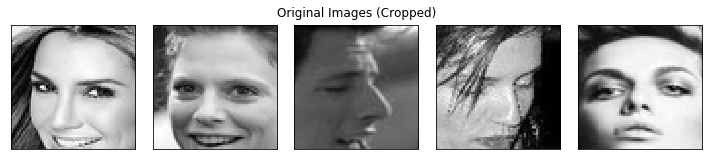

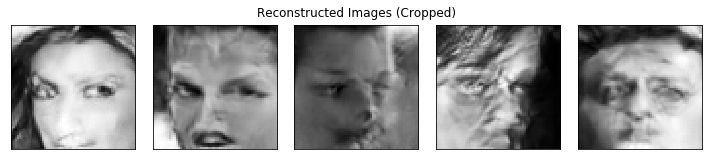

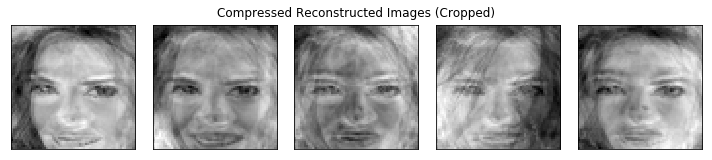

In [45]:
n_dim=25
#First, we need to unravel our eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Original Images (Cropped)'
plot_image_grid(original_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()    

plot_title='Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

plot_title='Compressed Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped_compressed[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

### 50-dimension compression

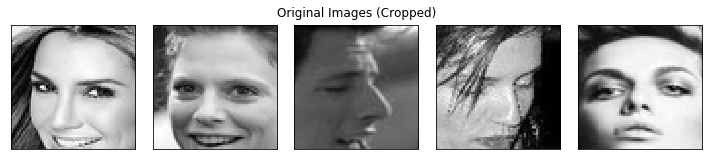

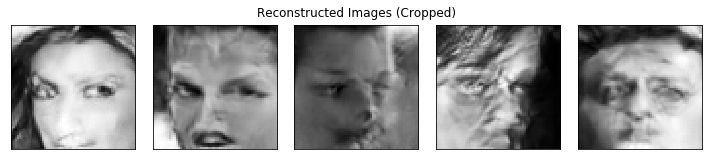

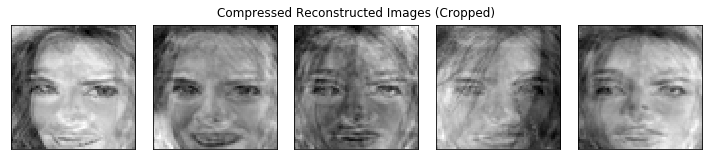

In [46]:
n_dim=50
#First, we need to unravel our eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Original Images (Cropped)'
plot_image_grid(original_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()    

plot_title='Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

plot_title='Compressed Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped_compressed[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

### 100-dimension compression

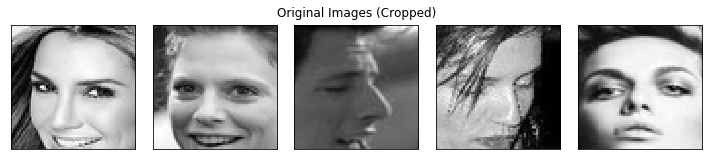

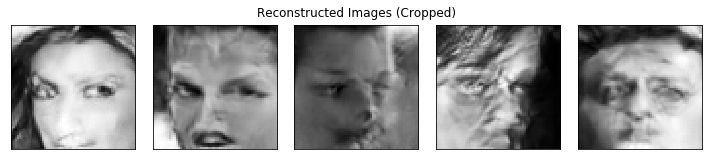

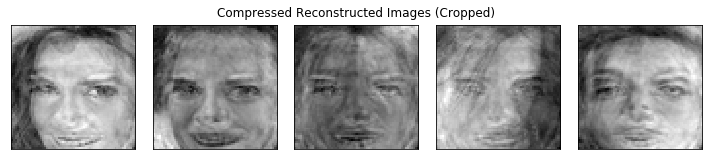

In [47]:
n_dim=100
#First, we need to unravel our eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Original Images (Cropped)'
plot_image_grid(original_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()    

plot_title='Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

plot_title='Compressed Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped_compressed[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

### 250-dimension compression

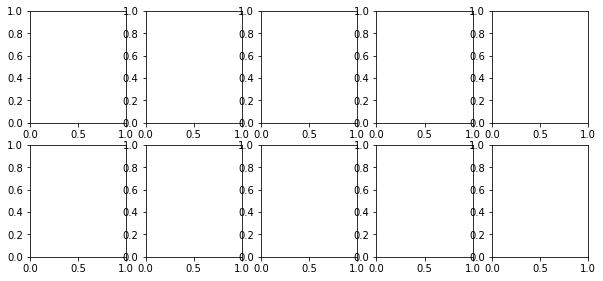

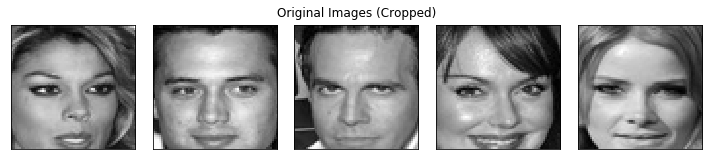

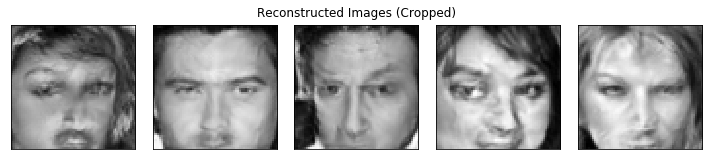

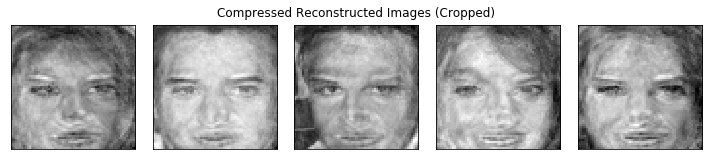

In [51]:
n_dim=250
#First, we need to unravel our eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Original Images (Cropped)'
plot_image_grid(original_cropped[5:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()    

plot_title='Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped[5:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

plot_title='Compressed Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped_compressed[5:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

# Reconstructed images analyzed over original Prin.Comp.

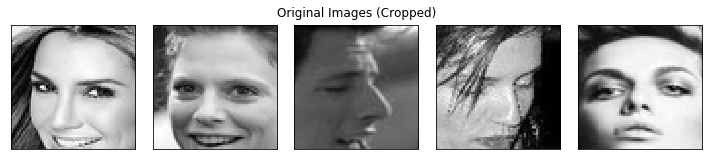

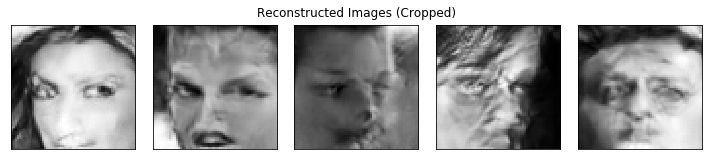

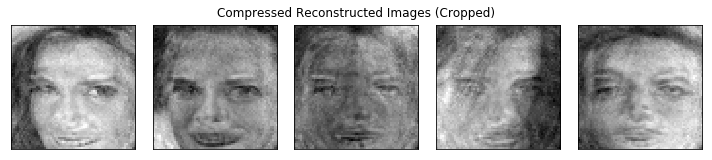

In [49]:
n_dim=500
#First, we need to unravel our !original! eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Original Images (Cropped)'
plot_image_grid(original_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()    

plot_title='Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

plot_title='Compressed Reconstructed Images (Cropped)'
plot_image_grid(recons_cropped_compressed[0:5],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=1
               )
plt.show()

### dimension=1000

In [50]:
n_dim=1000
#First, we need to unravel our !original! eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Ten original images'
plot_image_grid(original_cropped[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )
plt.show()    

plot_title='Ten reconstructed images'
plot_image_grid(recons_cropped[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )
plt.show()

plot_title='Ten compressed reconstructed images'
plot_image_grid(recons_cropped_compressed[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

# Rescaling Analysis

There are three things we will compare:
    - 1. Original-cropped dataset eigenvectors: 64x64 
    - 2. Original-cropped dataset eigenvectors: 64x64 resized to 32x32 via gaussian pyramid, then 32x32 eigenvectors computed
    - 3. Reconstructed-cropped dataset eigenvectors: 64x64 resized to 32x32
    

In [54]:
def resize_image_in_half(image):
    output_image = np.zeros((int(image.shape[0]/2),int(image.shape[1]/2)))
    for ii in range(int(image.shape[0]/2)):
        for jj in range(int(image.shape[1]/2)):
            output_image[ii,jj] = (image[2*ii,2*jj] +
                                   image[2*ii+1,2*jj] + 
                                   image[2*ii,2*jj+1] + 
                                   image[2*ii+1,2*jj+1]
                                  )/4
    return output_image
    

In [55]:
file1='../analysis_data/celebA_orig_cropped_eigen.p'
file2='../analysis_data/celebA_recons_cropped_eigen.p'
orig_cropped_eig=pickle.load(open(file1,'rb'))
recons_cropped_eig=pickle.load(open(file2,'rb'))

input_image_dir = '../nn_output/'
original_images_path_list = []
for file in os.listdir(input_image_dir):
    if file.endswith("orig.png"):
        original_images_path_list.append(file)
original_images = [rgb2gray(plt.imread(input_image_dir+file)) for file in sorted(original_images_path_list)]
original_cropped = [image[32:(32+64), 32:(32+64)] for image in original_images]

reconstructed_images_path_list = []

for file in os.listdir(input_image_dir):
    if file.endswith("recons.png"):
        reconstructed_images_path_list.append(file)

recons_images = [rgb2gray(plt.imread(input_image_dir+file)) for file in sorted(reconstructed_images_path_list)]
recons_cropped = [image[32:(32+64), 32:(32+64)] for image in recons_images]

### Cosine similarity of principal eigenvectors

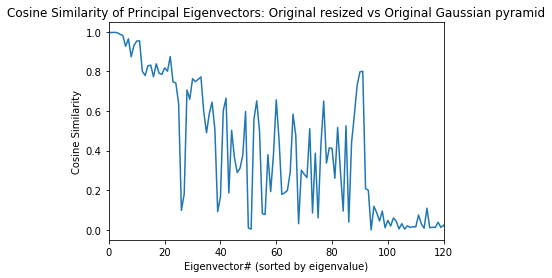

In [30]:
orig_cropped_eig_images_64 = orig_cropped_eig[0][1]
orig_cropped_eig_images_32 = orig_cropped_eig[1][1]
similarity_list = []
for ii in range(1,500):
    #Original cropped dataset vector
    first_eig_image_64 = orig_cropped_eig_images_64[-ii]
    first_eig_image_32_resized = resize_image_in_half(first_eig_image_64) 
    # Need to rescale after resizing
    first_eig_image_32_resized = first_eig_image_32_resized*1/np.linalg.norm(first_eig_image_32_resized) #eigenvector after resizing
    
    first_eig_image_32 = orig_cropped_eig_images_32[-ii] # eigenvector after gaussian pyramid

    #Now, unravel and compute similarity
    first_eig_vec_32_resized = unravel_image(first_eig_image_32_resized)
    first_eig_vec_32 = unravel_image(first_eig_image_32)
    
    similarity = np.abs(first_eig_vec_32@first_eig_vec_32_resized)
    similarity_list.append(similarity)
plt.plot(similarity_list)
plt.title("Cosine Similarity of Principal Eigenvectors: Original resized vs Original Gaussian pyramid")
plt.ylabel('Cosine Similarity')
plt.xlabel('Eigenvector# (sorted by eigenvalue)')
plt.xlim([0,120])
plt.show()


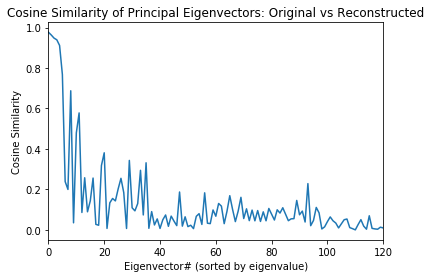

In [56]:
orig_cropped_eig_images_64 = orig_cropped_eig[0][1]
recons_cropped_eig_images_32 = recons_cropped_eig[1][1]
similarity_list = []
for ii in range(1,500):
    #Original cropped dataset vector
    first_eig_image_64 = orig_cropped_eig_images_64[-ii]
    first_eig_image_32_resized = resize_image_in_half(first_eig_image_64) 
    # Need to rescale after resizing
    first_eig_image_32_resized = first_eig_image_32_resized*1/np.linalg.norm(first_eig_image_32_resized) #eigenvector after resizing
    
    recons_eig_image_32 = recons_cropped_eig_images_32[-ii] # eigenvector after gaussian pyramid

    #Now, unravel and compute similarity
    first_eig_vec_32_resized = unravel_image(first_eig_image_32_resized)
    recons_eig_vec_32 = unravel_image(recons_eig_image_32)
    
    similarity = np.abs(recons_eig_vec_32@first_eig_vec_32_resized)
    similarity_list.append(similarity)
plt.plot(similarity_list)
plt.title("Cosine Similarity of Principal Eigenvectors: Original vs Reconstructed")
plt.ylabel('Cosine Similarity')
plt.xlabel('Eigenvector# (sorted by eigenvalue)')
plt.xlim([0,120])
plt.show()

In [ ]:
first_eig_image_64.shape

In [ ]:
second_eig_image_64.shape

In [ ]:
plot_image_grid(orig_cropped_eig_image_64[-10:],'test',image_shape=original_cropped_compressed[0].shape)

In [ ]:
n_dim=1000
orig_cropped_eig_image_64[0]
#First, we need to unravel our !original! eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0] * orig_eig_images[0].shape[1]

image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)

    
#Now,we unravel each !reconstructed! cropped image, and then project onto the eigenvectors
recons_cropped_compressed = []   
for image in recons_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    recons_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))

plot_title='Ten original images'
plot_image_grid(original_cropped[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )
plt.show()    

plot_title='Ten reconstructed images'
plot_image_grid(recons_cropped[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )
plt.show()

plot_title='Ten compressed reconstructed images'
plot_image_grid(recons_cropped_compressed[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )
plt.show()
